In [52]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import Locator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import os
from copy import deepcopy
import glob, os

def find_nearest_idx(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx - 1]) < math.fabs(value - array[idx])):
        return idx - 1
    else:
        return idx
    
def find_nearest(array, value):
    idx = find_nearest_idx(array, value)
    return array[idx]


# needed for correctly display tics for symlog scale
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """

    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]  # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (
                dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0] * 10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0] - self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (
                dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1] * 10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1] + self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i - 1]
            if abs(majorlocs[i - 1] + majorstep / 2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i - 1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

def register_div_cmap(zmin, zmax):
    diff = zmax - zmin
    w = np.abs(zmin / diff)  # white color point set to zero z value
    
    _cdict = {'red': ((0.0, 0.0, 0.0),
                   (w/2, 0.0, 0.0),
                   (w, 1.0, 1.0),
                   (w+(1-w)/3, 1.0, 1.0),
                   (w+(1-w)*2/3, 1.0, 1.0),
                   (1.0, 0.3, 0.3)),

            'green': ((0.0, 0, 0),
                   (w/2, 0.0, 0.0),
                   (w, 1.0, 1.0),
                   (w+(1-w)/3, 1.0, 1.0),
                   (w+(1-w)*2/3, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

            'blue':  ((0.0, 0.3, 0.3),
                   (w/2, 1.0, 1.0),
                   (w, 1.0, 1.0),
                   (w+(1-w)/3, 0.0, 0.0),
                   (w+(1-w)*2/3, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
            }

    custom_cmap = LinearSegmentedColormap('diverging', _cdict)
    cm.register_cmap('diverging', custom_cmap)

In [120]:
# read dir to get all a? files
def get_groups(directory, condition=lambda grp_len: True):
    groups = []
    last_group = []
    last_name = ''
    for file in glob.glob(os.path.join(directory + '\*.a?')):

        path = os.path.splitext(file)[0]
        name = os.path.split(path)[1]
        
#         print(name)

        if last_name == '':
            last_name = name

        if last_name == name:
            last_group.append(file)
        else:
            if condition(len(last_group)):
                groups.append(last_group)
                
            last_group = []
            last_name = name
            last_group.append(file)

    if condition(len(last_group)):
        groups.append(last_group)
    
    return groups
    
# class data for storing data matrix
class Data():
    def __init__(self, fname, delimiter='\t', t_axis_mul=1e-3):
        try:
            self.fname = fname
            data = np.loadtxt(fname, delimiter=delimiter, skiprows=0, dtype=np.float64)
            self.wavelengths = data[0, 1:]
            self.times = data[1:, 0] * t_axis_mul
            self.D = data[1:, 1:]
        except:
            print(self.fname)
        
    def __str__(self):
        if self.D is not None:
            return(f'{self.fname}: {str(self.D.shape)}')

def load_groups(groups):
    n_rows = len(groups)
    n_cols = max(len(g) for g in groups)

    data = np.empty((n_rows, n_cols), dtype=Data)
    for i, group in enumerate(groups):
        for j, fname in enumerate(group):
            data[i, j] = Data(fname)
#             print(data[i, j])
            
    return data
    
    
def plot_matrix(data, t_axis_mul=1, t_unit='$ps$', cmap='diverging', z_unit='$\Delta A$ ($m$OD)'):
    
    n_rows = data.shape[0]
    n_cols = data.shape[1]
    
    plt.rcParams['figure.figsize'] = (5 * n_cols, 4 * n_rows)
    
    for i in range(n_rows):
        for j in range(n_cols):
            plt.subplot(n_rows, n_cols, j+1+i*n_cols)  # # of rows, # of columns, index counting form 1
            
            if data[i, j] is None:
                continue
                
            fname = data[i, j].fname

            zmin = data[i, j].D.min()
            zmax = data[i, j].D.max()

            register_div_cmap(zmin, zmax)

            x, y = np.meshgrid(data[i, j].wavelengths, data[i, j].times * t_axis_mul)  # needed for pcolormesh to correctly scale the image

            # plot data matrix D

            plt.pcolormesh(x, y, data[i, j].D, cmap=cmap, vmin=zmin, vmax=zmax)
            plt.colorbar(label=z_unit)
            plt.title(os.path.split(fname)[1])
            plt.ylabel(f'$\leftarrow$ Time delay ({t_unit})')
            plt.xlabel(r'Wavelength ($nm$) $\rightarrow$')

            plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
#     plt.savefig(fname='output.png', format='png', transparent=True, dpi=500)
    
    
def plot_data(data, symlog=False, title='TA data', t_unit='$ps$', 
              z_unit='$\Delta A$ (mOD)', cmap='diverging', zmin=None, zmax=None,
              w0=None, w1=None, t0=None, t1=None, fig_size=(6, 4), dpi=500, filepath=None, transparent=True,
              linthresh=10, linscale=1, D_mul_factor=1e3):

    plt.rcParams['figure.figsize'] = fig_size
    # plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.23, hspace=0.26)
    
    times = data.times
    wavelengths = data.wavelengths
    D = data.D * D_mul_factor

    # cut data if necessary

    t_idx_start = find_nearest_idx(times, t0) if t0 is not None else 0
    t_idx_end = find_nearest_idx(times, t1) + 1 if t1 is not None else D.shape[0]

    wl_idx_start = find_nearest_idx(wavelengths, w0) if w0 is not None else 0
    wl_idx_end = find_nearest_idx(wavelengths, w1) + 1 if w1 is not None else D.shape[1]

    # crop the data if necessary
    D = D[t_idx_start:t_idx_end, wl_idx_start:wl_idx_end]
    times = times[t_idx_start:t_idx_end]
    wavelengths = wavelengths[wl_idx_start:wl_idx_end]
    
    zmin = np.min(D) if zmin is None else zmin
    zmax = np.max(D) if zmax is None else zmax
    
    register_div_cmap(zmin, zmax)
    
    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image

    # plot data matrix D

    plt.pcolormesh(x, y, D, cmap=cmap, vmin=zmin, vmax=zmax)

    plt.colorbar(label=z_unit)
    plt.title(title)
    plt.ylabel(f'$\leftarrow$ Time delay ({t_unit})')
    plt.xlabel(r'Wavelength ($nm$) $\rightarrow$')

    plt.gca().invert_yaxis()

    if symlog:
        plt.yscale('symlog', subsy=[2, 3, 4, 5, 6, 7, 8, 9], linscaley=linscale, linthreshy=linthresh)
        yaxis = plt.gca().yaxis
        yaxis.set_minor_locator(MinorSymLogLocator(linthresh))
    
    plt.tight_layout()

    # save to file
    if filepath:
        ext = os.path.splitext(filepath)[1].lower()[1:]
        plt.savefig(fname=filepath, format=ext, transparent=transparent, dpi=dpi)
        
    plt.show()
    
    
# averaging
def average(data):
    data_avrg = np.empty(data.shape[0], dtype=Data)
    for i in range(data.shape[0]):
        D_total = data[i, 0].D
        n = 1
        for j in range(1, data.shape[1]):
            if data[i, j] is not None:
                D_total += data[i, j].D
                n += 1
        D_total /= n
        data_avrg[i] = deepcopy(data[i, 0])
        data_avrg[i].D = D_total
        data_avrg[i].fname += '-avrg'
        
    return data_avrg

# merge multiple datasets
def merge(data_avrg):
    to_sort = []
    for m in data_avrg:
        for i in range(m.times.shape[0]):
            to_sort.append([m.times[i], m.D[i]])

    _sorted = sorted(to_sort, key=lambda x: x[0])
    
    last = _sorted[0][0]
    i0, l = 0, 0
    processed = True

    while processed:
        processed = False
        for i in range(len(_sorted)):
            if _sorted[i][0] == last:
                l += 1
            else:
                if l > 1:
                    processed = True
                    avrg = _sorted[i0][1]
#                     cut = _sorted[i0+1: i0 + l]
                    for j in range(i0+1, i0 + l):
                        avrg += _sorted[j][1]
                        
                    _sorted[i0][1] = avrg / l
                    del _sorted[i0+1: i0 + l]
                    i0, l = 0, 0
                    break
                i0 = i
                l = 1
                last = _sorted[i][0]
        if l > 1:
            processed = True
            avrg = _sorted[i0][1]
#             cut = _sorted[i0+1: i0 + l]
            for j in range(i0+1, i0 + l):
                avrg += _sorted[j][1]

            _sorted[i0][1] = avrg / l
            del _sorted[i0 + 1: i0 + l]
            i0, l = 0, 0
            
    final_data = deepcopy(data_avrg[0])
    t_dim = len(_sorted)
    final_data.times = np.zeros(t_dim)
    final_data.D = np.zeros((t_dim, final_data.wavelengths.shape[0]))
    for i in range(t_dim):
        final_data.times[i] = _sorted[i][0]
        final_data.D[i] = _sorted[i][1]
    
    return final_data

# Read and plot multiple datasets
### List all *a? files in directory

In [115]:
_dir = r'C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\Python scripts\Heat map plotter\190319_fs_fla_NF'  # directory to read

groups = get_groups(_dir)
groups

[['C:\\Users\\Dominik\\Documents\\MUNI\\Organic Photochemistry\\Projects\\Python scripts\\Heat map plotter\\190319_fs_fla_NF\\2019_03_19_FLA_NF_MeOH_20ps_1.a0',
  'C:\\Users\\Dominik\\Documents\\MUNI\\Organic Photochemistry\\Projects\\Python scripts\\Heat map plotter\\190319_fs_fla_NF\\2019_03_19_FLA_NF_MeOH_20ps_1.a1',
  'C:\\Users\\Dominik\\Documents\\MUNI\\Organic Photochemistry\\Projects\\Python scripts\\Heat map plotter\\190319_fs_fla_NF\\2019_03_19_FLA_NF_MeOH_20ps_1.a2'],
 ['C:\\Users\\Dominik\\Documents\\MUNI\\Organic Photochemistry\\Projects\\Python scripts\\Heat map plotter\\190319_fs_fla_NF\\2019_03_19_FLA_NF_MeOH_20ps_2.a0'],
 ['C:\\Users\\Dominik\\Documents\\MUNI\\Organic Photochemistry\\Projects\\Python scripts\\Heat map plotter\\190319_fs_fla_NF\\2019_03_19_FLA_NF_MeOH_20ps_3.a0',
  'C:\\Users\\Dominik\\Documents\\MUNI\\Organic Photochemistry\\Projects\\Python scripts\\Heat map plotter\\190319_fs_fla_NF\\2019_03_19_FLA_NF_MeOH_20ps_3.a1',
  'C:\\Users\\Dominik\\Documents

### Plot all data

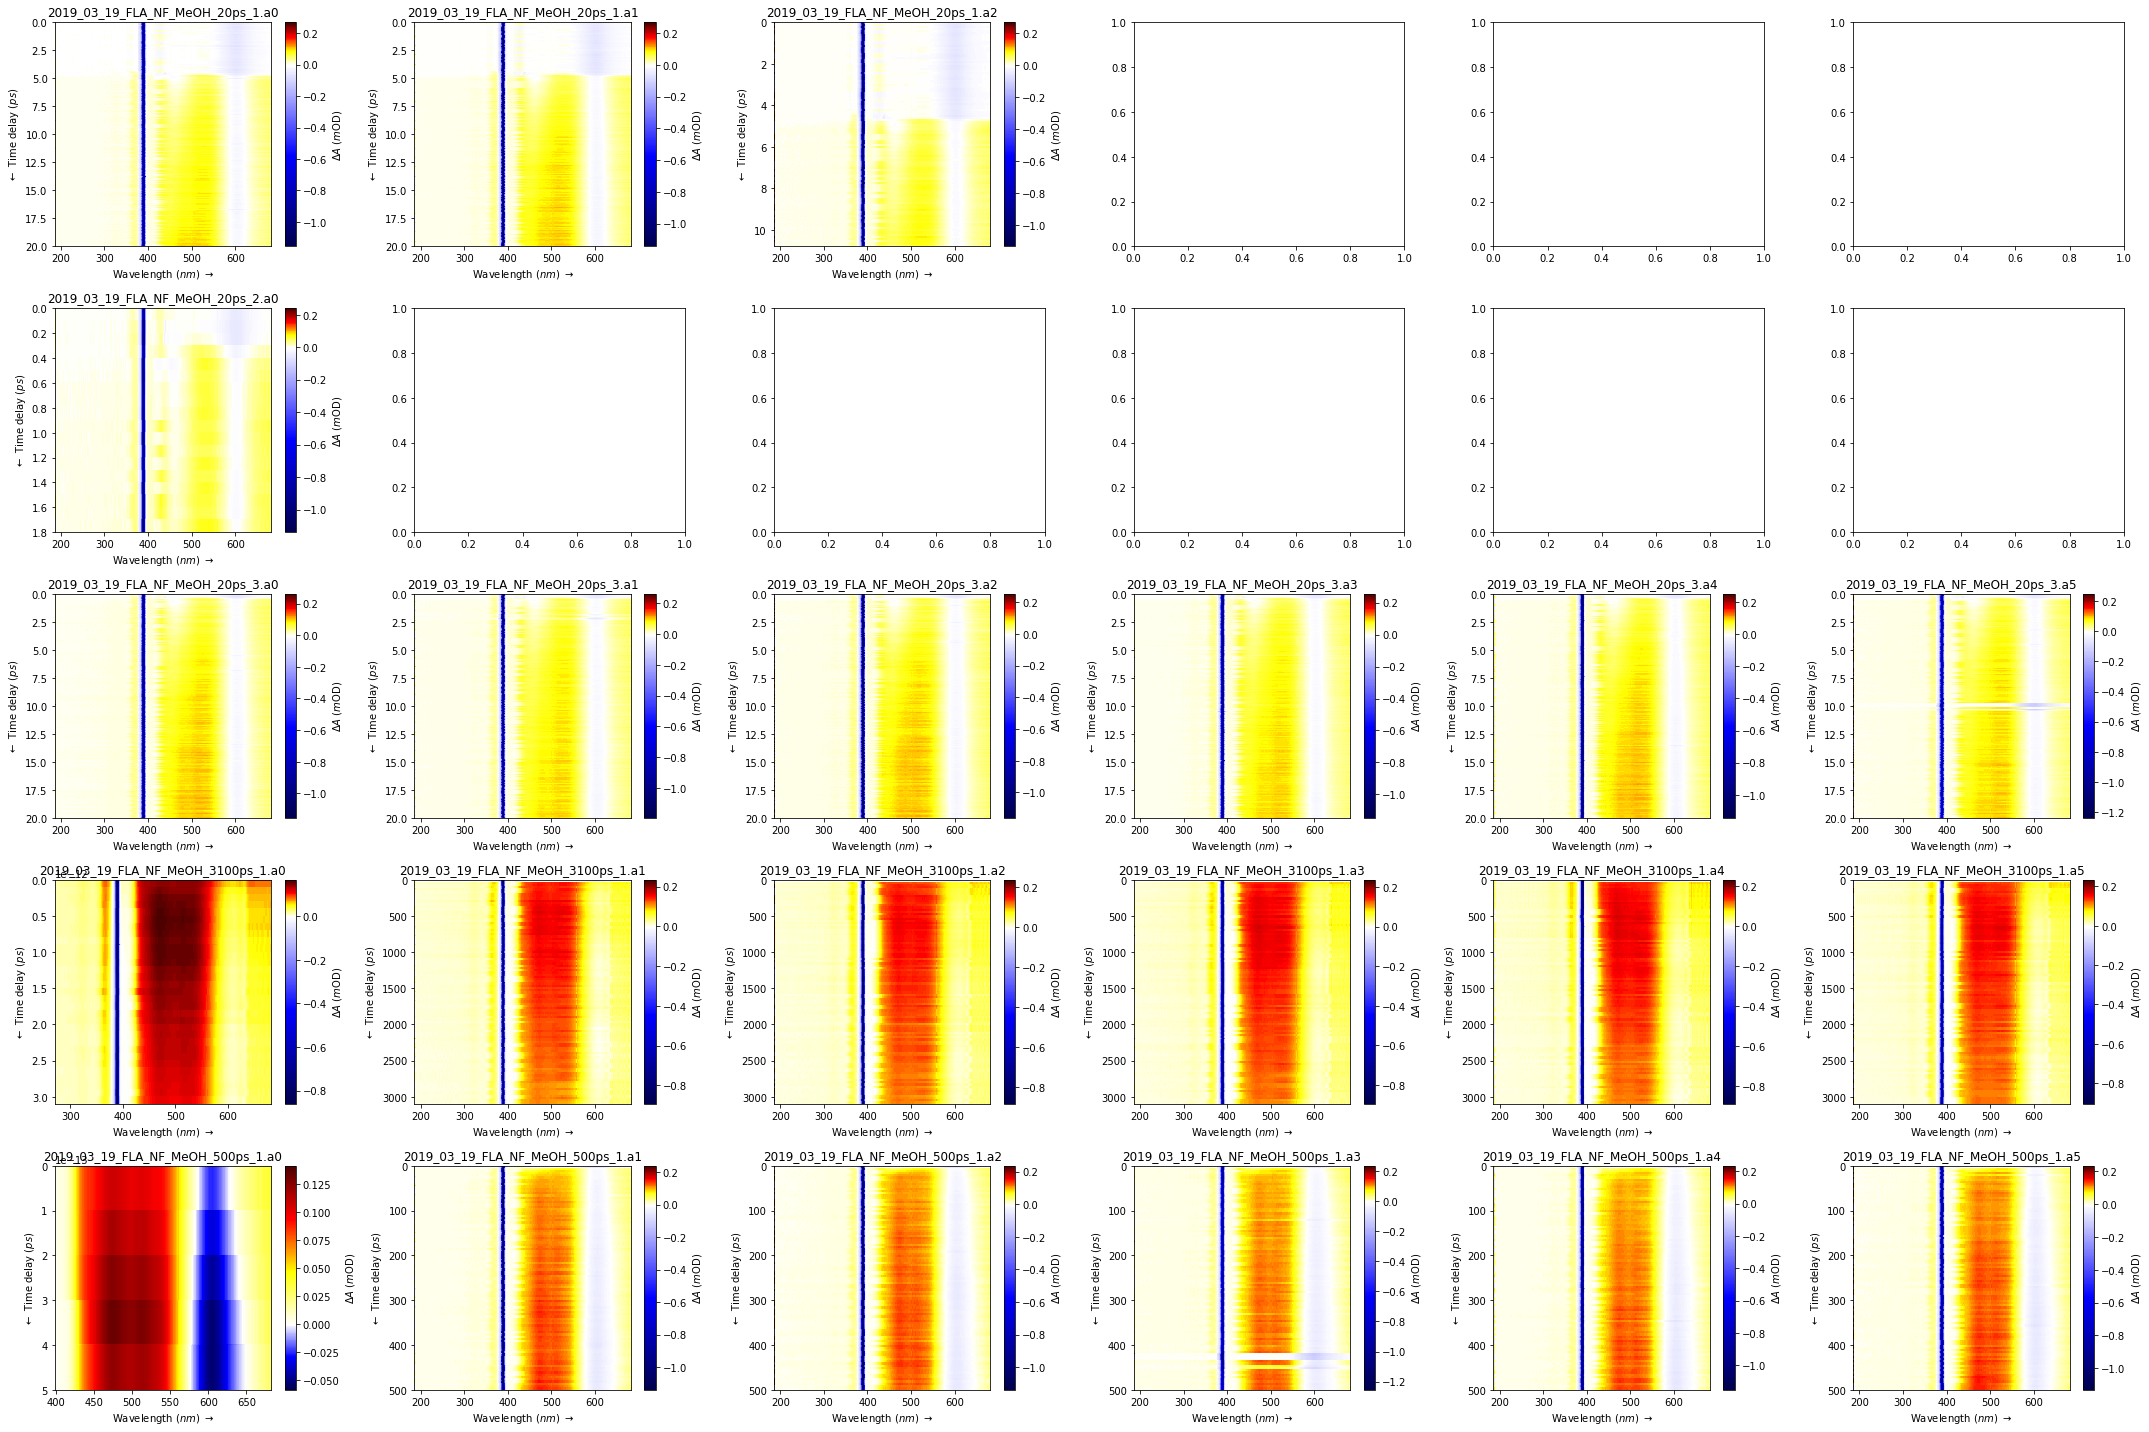

In [122]:
data = load_groups(groups)
plot_matrix(data)

### Select data

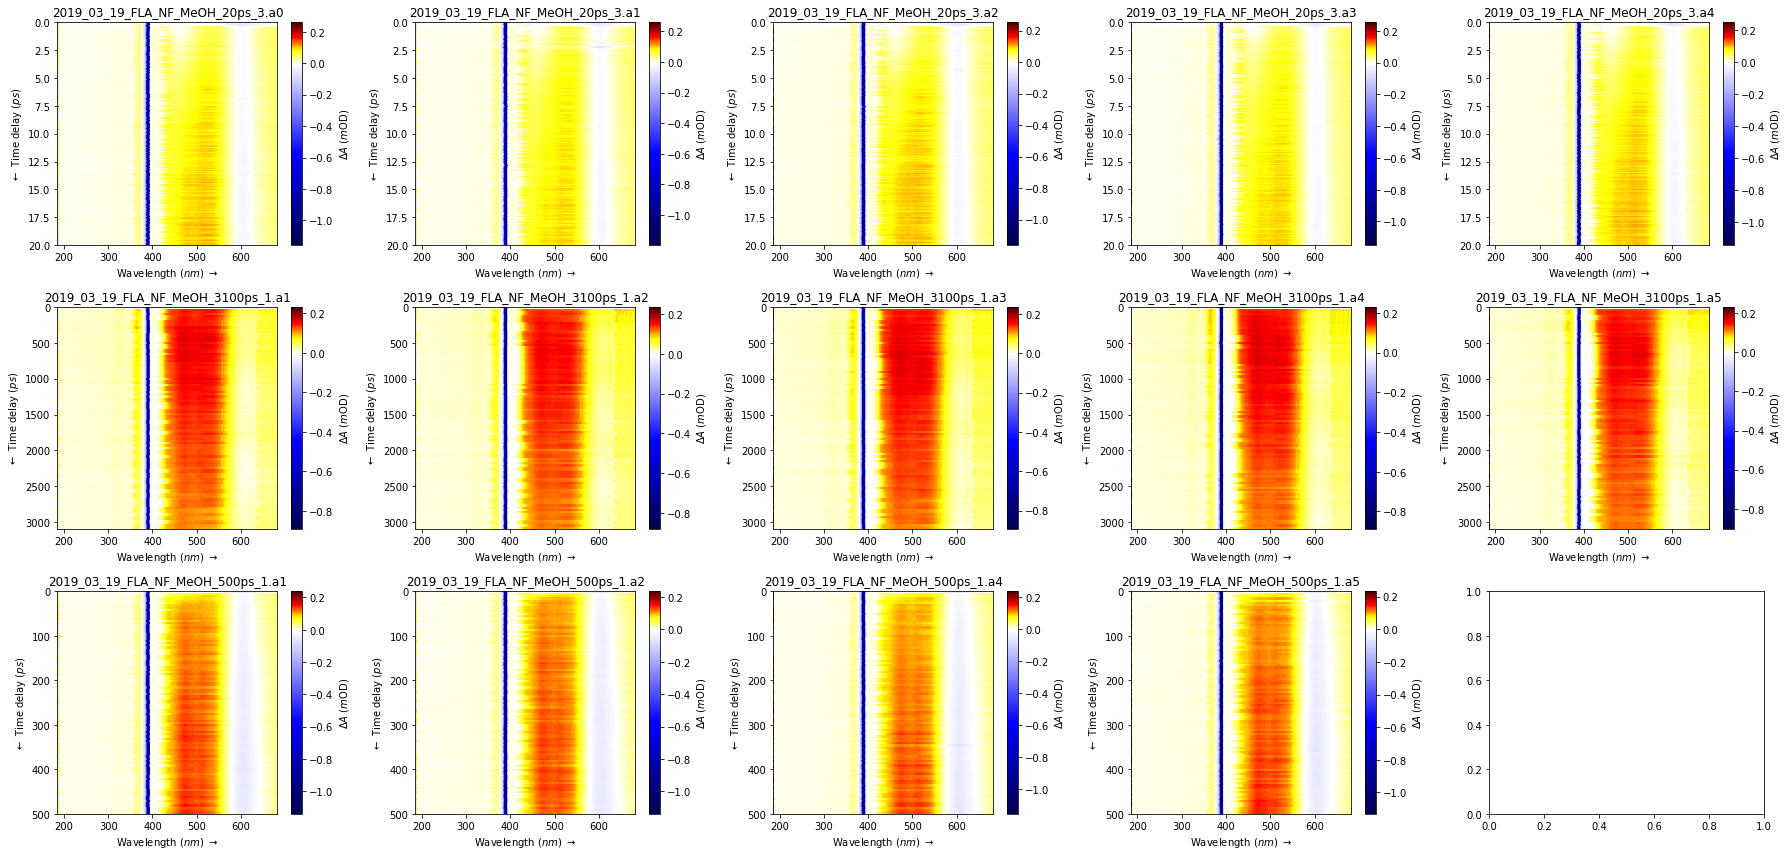

In [127]:
# select only datasets that consists of more than 5 measurements, i.e. file a0 - a5
g1 = get_groups(_dir, condition=lambda grp_len: grp_len > 3)
del g1[1][0]
del g1[2][3]
del g1[2][0]
del g1[0][5]

# del g1[:2]

g1

data = load_groups(g1)
plot_matrix(data)


## Average datasets

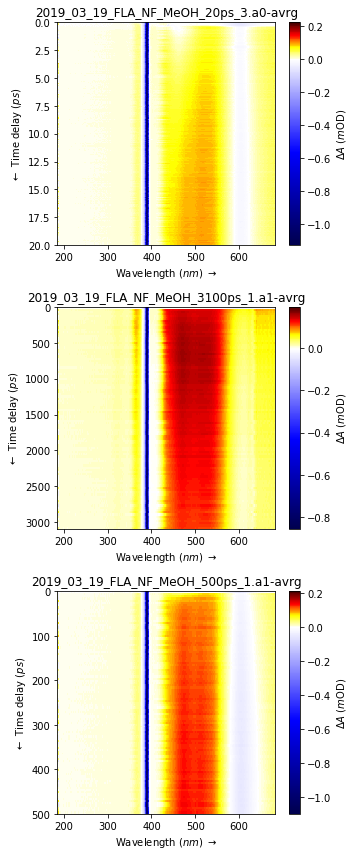

In [128]:
data_avrg = average(data)

plot_matrix(data_avrg.reshape((-1, 1)))

# Merge datasets and plot

In [129]:
final_data = merge(data_avrg)

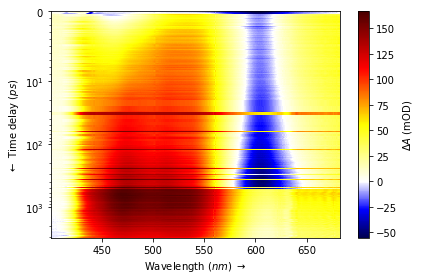

In [136]:

plot_data(final_data, D_mul_factor=1e3, symlog=True, t0=0, t1=None, w0=400, w1=None, fig_size=(6, 4),
          cmap='diverging', t_unit='$ps$', title='', filepath=None, dpi=500, linthresh=10, linscale=1, zmin=None, zmax=None)

In [114]:
def save_matrix_to_Glotaran(data, fname='output-GLOTARAN-long.ascii', delimiter='\t', encoding='utf8'):
    mat = np.vstack((data.wavelengths, data.D))
#     t = np.concatenate([[0], data.times * 1e-3])
#     mat = np.hstack((t.reshape(-1, 1), mat))
    
    buffer = f'Header\nOriginal filename: fname\nTime explicit\nintervalnr {data.times.shape[0]}\n'
    buffer += delimiter + delimiter.join(f"{num}" for num in data.times) + '\n'
    buffer += '\n'.join(delimiter.join(f"{num}" for num in row) for row in mat.T)
    
    with open(fname, 'w', encoding=encoding) as f:
        f.write(buffer)
    
#     np.savetxt(fname, mat, delimiter=delimiter)
    

save_matrix_to_Glotaran(final_data, fname='2020_01_23_E_10ps-GLOTARAN.ascii')

# Baseline correction

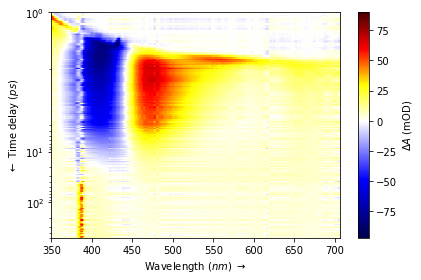

In [100]:
def baseline_corr(data, t0=0, t1=300):
    t_idx_start = find_nearest_idx(data.times, t0) if t0 is not None else 0
    t_idx_end = find_nearest_idx(data.times, t1) + 1 if t1 is not None else data.D.shape[0]
    
    # crop the data if necessary
    D_cut = data.D[t_idx_start:t_idx_end, :]
    avrg = np.average(D_cut, axis=0)
    
    data.D -= avrg
    
    return data

final_data = baseline_corr(final_data, t0=0, t1=0.5)

plot_data(final_data, D_mul_factor=1e3, symlog=True, t0=1, t1=None, w0=350, w1=None, fig_size=(6, 4),
          cmap='diverging', t_unit='$ps$', title='', filepath=None, dpi=500, linthresh=3, linscale=3, zmin=None, zmax=None)


In [64]:
### ! CHANGE THE FILENAME OF YOUR DATA HERE !
fname = 'Andrea/2019_11_05_Zn_TcPP_MeOH_3100ps_filtr_1.a0-AVERAGE_SPECFIT.txt'

fname_no_ext = os.path.splitext(fname)[0].lower()
data = np.loadtxt(fname, delimiter='\t', skiprows=3, dtype=np.float64)
times = data[0, 1:]
wavelengths = data[1:, 0]
D = data[1:, 1:].T  # also, transpose the data, so that rows contains spectra and columns traces

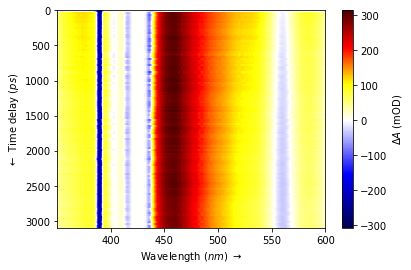

In [69]:
filepath = fname_no_ext + '.png'

plot_data(D*1e3, times*1e-3, wavelengths, symlog=False, t0=1, t1=None, w0=350, w1=600, fig_size=(6, 4),
          cmap='diverging', t_unit='$ps$', title='', filepath=None, dpi=500)
